<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/knn_sample_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN: Sample Design
## In this notebook we will create a well spread and balanced sample to estimate Percent Forest Cover for Custer Gallatin Forest using [Raster Tools](https://github.com/UM-RMRS/raster_tools) and remotely sensed imagery
### Objectives
- Learn about sample designs
- Learn how to access remotely sensed data (OSM, STAC, & WCS)
- Learn how to create a well spread and balanced sample that will be used to estimate percent forest cover

### Datasets
- Forest Boundary (OSM)
- Landsat Imagery (STAC, plantary computer)
- 0-100% [MRLC Canopy Cover](https://www.mrlc.gov/data-services-page) (WCS)

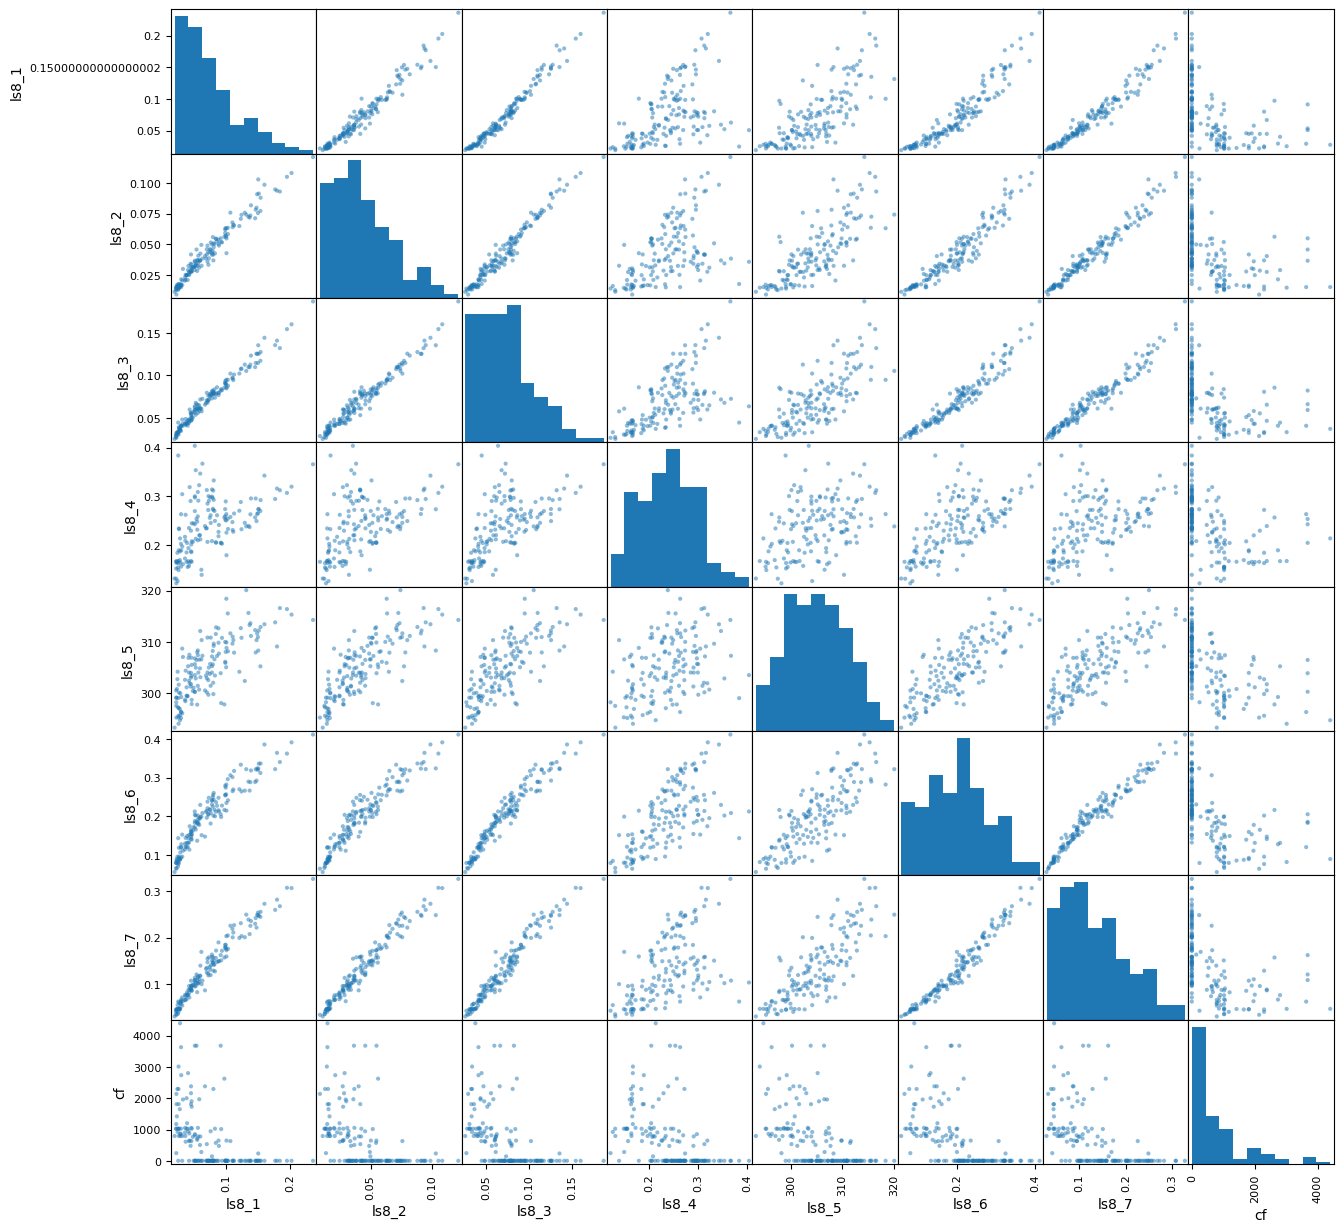

### Steps
1. Create a large random sample for a study area
2. Extract remotely sensed data for each location
3. Create a systematic random sample from the sorted list
4. Look at the distributions of the sample

by John Hogland 3/26/2024

## Install software

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac
!pip install hilbertcurve
!pip install owslib

## Import packages

In [ ]:
#get packages
import osmnx as ox, planetary_computer, pystac_client, stackstac
import geopandas as gpd, pandas as pd, os, numpy as np, requests, urllib

from hilbertcurve.hilbertcurve import HilbertCurve
from raster_tools import Raster,zonal
from owslib.wcs import WebCoverageService

from shapely import geometry
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier


## Step 1: Create a large random sample
- Get the NF boundary
- Allocate 10,000 random locations

### Create Definitions

In [ ]:
#Create a random sample definition
def get_random_sample(geom_p, n=1000):
    """
    produces a random sample given a geometry

    parameters:
    geom_p = (polygon) project polygon
    n = number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = geom_p.total_bounds
    xdif = xmax - xmin
    ydif = ymax - ymin
    pnts_lst = []
    while len(pnts_lst) < n:
        x = (np.random.random() * xdif) + xmin
        y = (np.random.random() * ydif) + ymin
        pnt = geometry.Point([x, y])
        if pnt.intersects(geom_p).values:
            pnts_lst.append(pnt)

    dic = {"geometry": pnts_lst}
    gdf = gpd.GeoDataFrame(dic, crs=geom_p.crs)

    return gdf



### Create Sample

In [ ]:
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#us random sample function to create 10,000 locations within the nf1
pnts=get_random_sample(nf1p,10000)

#Visualize the nf1 and sample locations
m=nf1p.explore()
m=pnts.explore(m=m,color='yellow')
m

## Step 2: Extract remotely sensed data for each location
### Create definitions

In [ ]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic

#Create definition to extract image service data
def get_image_service_data(url, ply, out_prefix,res=30,outSR=""):
    '''
    extracts a list of images from a image service given a url, polygon, and output prefix name

    url = (string) path to image service e.g., url=r'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF230/US_230EVT/ImageServer'
    ply = (geoseries or geodataframe) of the study area
    out_prefix = (string) prefix used to save each image
    '''
    layerInfo=requests.get(url+'?f=pjson')
    dic=layerInfo.json()
    #print(dic)
    spr=dic['spatialReference']
    m_width=dic['maxImageWidth']
    m_height=dic['maxImageHeight']
    fitem=next(iter(spr))
    ply2=ply.to_crs(spr[fitem])

    xmin,ymin,xmax,ymax=ply2.total_bounds

    wcells=int((xmax-xmin)/res)
    hcells=int((ymax-ymin)/res)

    if(wcells<m_width):
        m_width=wcells

    if(hcells<m_height):
        m_height=hcells


    wcells_l=np.arange(0,wcells,m_width)
    hcells_l=np.arange(0,hcells,m_height)

    xmax2=xmin
    ymax2=ymin

    tile=1

    rs_lst=[]
    for w in wcells_l:
        for h in hcells_l:
            xmax2 = (m_width*res+xmax2)
            ymax2 = (m_height*res+ymax2)

            qry = url+'/exportImage?'
            parm = {
                'f':'json',
                'bbox':','.join([str(xmin),str(ymin),str(xmax2),str(ymax2)]),
                'size':str(m_width) + ',' + str(m_height),
                'imageSR':outSR,
                'format':'tiff'
            }
            #print(parm['bbox'])
            response=requests.get(qry,parm)
            if response.status_code == 200:
                img_url=response.json()['href']
                outname=out_prefix + str(tile) + '.tif'
                urllib.request.urlretrieve(img_url, outname)
                rs_lst.append(Raster(outname))
                tile+=1

    return rs_lst

# Create definition for WCS download
def get_wcs_data(url,ply,service_name='mrlc_download__nlcd_tcc_conus_2021_v2021-4',out_prefix = 'tcc'):
    '''
    Extracts saves an image from a WCS given url, polygon boundary, and service name. Images are saved in the same location as the notebook.
    url = (string) path to wcs e.g. 'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2021_v2021-4/wcs?'
    ply = (geoseries or geodataframe) of the study area
    service_name = (string) name of the service e.g. mrlc_download__nlcd_tcc_conus_2021_v2021-4
    out_prefix = (string) prefix used to save each image

    returns a Raster object
    '''
    wcs=WebCoverageService(url)
    tcc=wcs.contents[service_name]
    bbox=tuple(ply.total_bounds)
    subsets=[('X',bbox[0],bbox[2]),('Y',bbox[1],bbox[3])]
    rsp=wcs.getCoverage(identifier=[tcc.id],subsets=subsets,format='geotiff')
    outpath='./'+out_prefix+'.tif'
    with open(outpath,'wb') as file:
        file.write(rsp.read())

    return Raster(outpath)


### Extract data

In [ ]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

#get REST data forest canopy cover
# if(not os.path.exists('cf1.tif')):
#     url=r'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/NLCD_2016_TreeCanopyCover_CONUS/ImageServer'
#     im_lst=get_image_service_data(url=url,ply=nf1,out_prefix='cf',res=30,outSR=5070)
#     ccf_rs=im_lst[0]

outpath='cf1.tif'
if(not os.path.exists(outpath)): #if the 2016 tree canopy cover file does not exits, download it
    url=r'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2016_v2021-4/wcs?'
    sn='mrlc_download__nlcd_tcc_conus_2016_v2021-4'
    get_wcs_data(url=url,ply=nf1p,service_name=sn,out_prefix='cf1')


#Extract point data
ccf_rs=Raster('cf1.tif')
ccf_rs=ccf_rs
ls30s=Raster('ls82016.tif')

ls_tbl=zonal.extract_points_eager(pnts,ls30s,'ls8',axis=1).compute()
pred=ls_tbl.columns

ccf_tbl=zonal.extract_points_eager(pnts,ccf_rs,'cf',axis=1).compute()

#set null values -9999 to 0
vls=ccf_tbl['cf_1']
ccf_tbl['cf']=vls.where(vls>0,0)


#Join values to pnts geodataframe
bsmp=pnts.join(ls_tbl.join(ccf_tbl))

#visualize the data
display(bsmp)
pd.plotting.scatter_matrix(bsmp,figsize=(15,15))

## Step 3 Create systematic random sample using a sorted list and Hilbert distance (n=150)
### Create definitions

In [ ]:
def get_plots(bsmp,clm_nms,n=250,sys=False,euclidean=True,ordinate=True):
    '''
    bsmp (dataframe) =  population dataframe
    subarea (polygon geodataframe) = geodataframe of accessible areas
    clm_nms (list of strings) = list of column names used as predictor variables
    n (int) = sample size
    sys (bool) = used to determine if we are using a systematic random sample from a sorted list of distances or a simple random sample
    euclidean (bool) = used to determine how distance is calculated
    ordinate (bool) = specifies if Standard Scaler and PCA (True) or MinMaxScaler procedure is used (False) when using Hilbert distance


    returns a geodataframe of selected observations
    '''

    if(not ('plotid' in list(bsmp.columns))): bsmp['plotid']=bsmp.index

    #Normalize and center variable values
    X=bsmp[clm_nms]
    if(ordinate):
        ss=StandardScaler()
        ss.fit(X)
        X2=ss.transform(X)

        #Perform PCA, transform scaled values, and perform K-means classification
        pca=PCA()
        pca.fit(X2)
        X3=pca.transform(X2)*1000
        clm_nms2=[]
        for c in range(X3.shape[1]):
            clm_nms2.append('comp_' + str(c+1))
    else:
        mss=MinMaxScaler()
        mss.fit(X)
        X3=mss.transform(X)*1000
        clm_nms2=[]
        for c in range(X3.shape[1]):
            clm_nms2.append('s_' + str(c+1))

    bsmp=bsmp.join(pd.DataFrame(X3,columns=clm_nms2))

    if(sys):
        #calc distance, sort, and create random start to get ids
        X = bsmp[clm_nms2]
        if(euclidean):
          dist=((X-X.min(axis=0)).pow(2)).sum(axis=1)
        else:
          if(ordinate):
            X2=((X-X.min())).astype('int32')
          else:
            X2=X.astype('int32')

          p=int(np.log2(np.max(X2)))+1 #axes length
          n2=X2.shape[1]
          hilbert_curve = HilbertCurve(p, n2)
          dist = pd.Series(hilbert_curve.distances_from_points(X2.values),dtype='object')
        
        bsmp['dist']=dist

        id_sort=dist.sort_values()
        N=X.shape[0]
        skp=N/n
        st=np.random.randint(0,int(skp))
        idlst=np.arange(st,N,skp).astype('int32')
        ids2=id_sort.iloc[idlst].index

    else:
        #create a random sample from all locations
        ids2=np.random.choice(bsmp.index,n,replace=False)

    #subset the random sample (rsmp)
    rsmp=bsmp[bsmp.index.isin(ids2)]

    return rsmp,bsmp

### Create sample

In [ ]:
smp_t,bsmp_d = get_plots(bsmp=bsmp,clm_nms=pred,n=150,sys=True,euclidean=False,ordinate=True)
smp_t[list(pred)+['cf','geometry']].to_file('sb_sample.shp.zip')
bsmp[~bsmp['plotid'].isin(smp_t['plotid'])].to_file('validation.shp.zip')

### Visualize the sample

In [ ]:
smp = gpd.read_file('sb_sample.shp.zip')
display(smp)
smp.explore()

## Step 4: Look at the distribution of the spread and balanced sample

In [ ]:
display(smp[pred].describe())
display(bsmp[pred].describe())

In [ ]:
pd.plotting.scatter_matrix(smp[list(pred)+['cf']],figsize=(15,15))

### Perform a 2 sample KS test for both distance and % Canopy Cover and plot the distribution of % Canopy Cover for the big random sample and the spread and balanced sample.

In [ ]:
import scipy
import scipy.stats

#look at KS statistic for distance values bsmp_s vs smp_t
dks_test=scipy.stats.ks_2samp(bsmp_d['dist'].astype('f8'),smp_t['dist'].astype('f8')) #KS 2 sample test
print('KS test stat for dist =',dks_test.statistic,'\nKS pvalue for dist =',dks_test.pvalue)

dks_test2=scipy.stats.ks_2samp(bsmp_d['cf'].astype('f8'),smp_t['cf'].astype('f8')) #KS 2 sample test
print('\nKS test stat for % canopy cover =',dks_test2.statistic,'\nKS pvalue for AGB =',dks_test2.pvalue)

display(bsmp_d[['cf']].astype('f8').hist(density=True,figsize=(15,8)))
display(smp_t[['cf']].astype('f8').hist(density=True,figsize=(15,8),color='orange'))

In [ ]:
ls82016=Raster('ls82016.tif')
rgb2016=ls82016.get_bands([1,2,3])
p=smp.plot(color='yellow',figsize=(15,10))
p=nf1p.plot(ax=p,edgecolor='red',facecolor='none')
p=rgb2016.xdata.plot.imshow(ax=p,robust=True)
p